# MNIST 4: Netzwerk anders herum

Die Effizienz der Neuronalen Netzwerke hat einen Preis: Wir verstehen im Grunde nicht mehr wirklich, was geschieht. Im Fall der Zeichenerkennung können wir etwa keinen Algorithmus ableiten, den man dan implementieren und optimieren könnte. Wie kommt der Klassifizierer, das Netzwerk zu seiner Entscheidung? 

Wir wollen hier einmal versuchen, das Netzwerk von der anderen Seite zu betrachten. Jeder Input führt zu einem Zustand der Output-Neuronen, aus denen wir dann das Ergebnis ablesen. Dabei ist dieses Ergebnis nicht "scharf", in dem Sinne, dass etwa ein Output-Neuron den Wert 1 annimmt und alle anderend ein Wert 0. Stattdessen erhalten wir eher eine Reihe von Wahrscheinlichkeiten für einen Wert, aus dem wir dann den größten als Ergebnis betrachten.

Welche Input-Werte führen aber zu einem solchen _idealen_ Ergebnis, d.h. einem Zustand, in dem ein Output-Neuron den Wert 1 annimmt? Dazu drehen wir das neuronale Netzwerk einmal um und belegen die Output-Neuronen mit dem scharfen, idealen Output-Zustand, führen eine Propagation durch und sehen uns dann den Zustand der Output-Neuronen an.

In [1]:
import numpy as np

from ki_kurs.knn import NeuralNetwork
import matplotlib.pyplot as plt

Wir erweitern unsere Netzwerk-Klasse um eine weitere Funktion mit einem "Reverse Lookup". Hier legen wir die gewünschten Ausgabedaten an die Output-Neuroen an und durchlaufen das Netzwerk in umgekehrter Richtung, wobei wir die Gewichte und die skalare Multiplikationen unverändert lassen. lediglich die Transfer-Funktion müssen wir neu definieren: Was sie bei der Vorwärtsrichtung etwa die logistische Funktion, die auf einer Exponential-Funktion basierte, so haben wir es auf dem "Rückweg" mit einem Logarithmus zu tun.

### Die Logit-Funktion

In [2]:
logit = lambda x : np.log( x / (1-x))

### Reverse-Lookup in unserem Neuronalen Netzwerk

Mit der Logit-Funktion können wir nun den Weg zurück durch das Neuronale Netzwerk gehen:

In [3]:
class TwoWayNetwork(NeuralNetwork):
    ''' Erweitert das Neuronale Netzwerk um eine Reverse-Funktion '''
    def reverse(self, target):
        output = np.array(target, ndmin=2).T

        final_inputs = logit(output)

        hidden_outputs = np.dot(self.who.T, final_inputs)

        hidden_outputs -= np.min(hidden_outputs)
        hidden_outputs /= np.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01

        hidden_inputs = logit(hidden_outputs)

        inputs = np.dot(self.wih.T, hidden_inputs)
        # Skalierung auf Grauwerte
        inputs -= np.min(inputs)
        inputs /= np.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

### Laden des neuronalen Netzwerks

Wir erzeugen nun das Netzwerk wieder mit den vorgegeben Parametern, d.h. der Anzahl der Neuronen in den drei Schichten. und laden die vorher bestimmten Gewichte. Alles bleibt also gleich, aber unser Netzwerk hat nun eine zusätzliche Funktion:

In [4]:
network = TwoWayNetwork(28*28,100,10)
network.load("MNist")

### Rückwärts durch das neuronale Netzwerk

Mit der folgenden Funktion bestimmen wir den Input, der den optimalen Output für eine bestimmte Zahl erzeugt, und erzeugen und zeigen die Daten als Graustufenbild:

In [5]:
def create_output(n):
    output = np.zeros(10) + 0.01
    output[n] = 0.99
    return output;

def image_from_output(network,n):
    return network.reverse(create_output(n))

def show_image(data):
    plt.imshow(data.reshape(28,28), cmap='Greys', interpolation='None')

#### Wir sind gespannt...

Können wir verstehen, wie das neuronale Netzwerk etwas sieht?

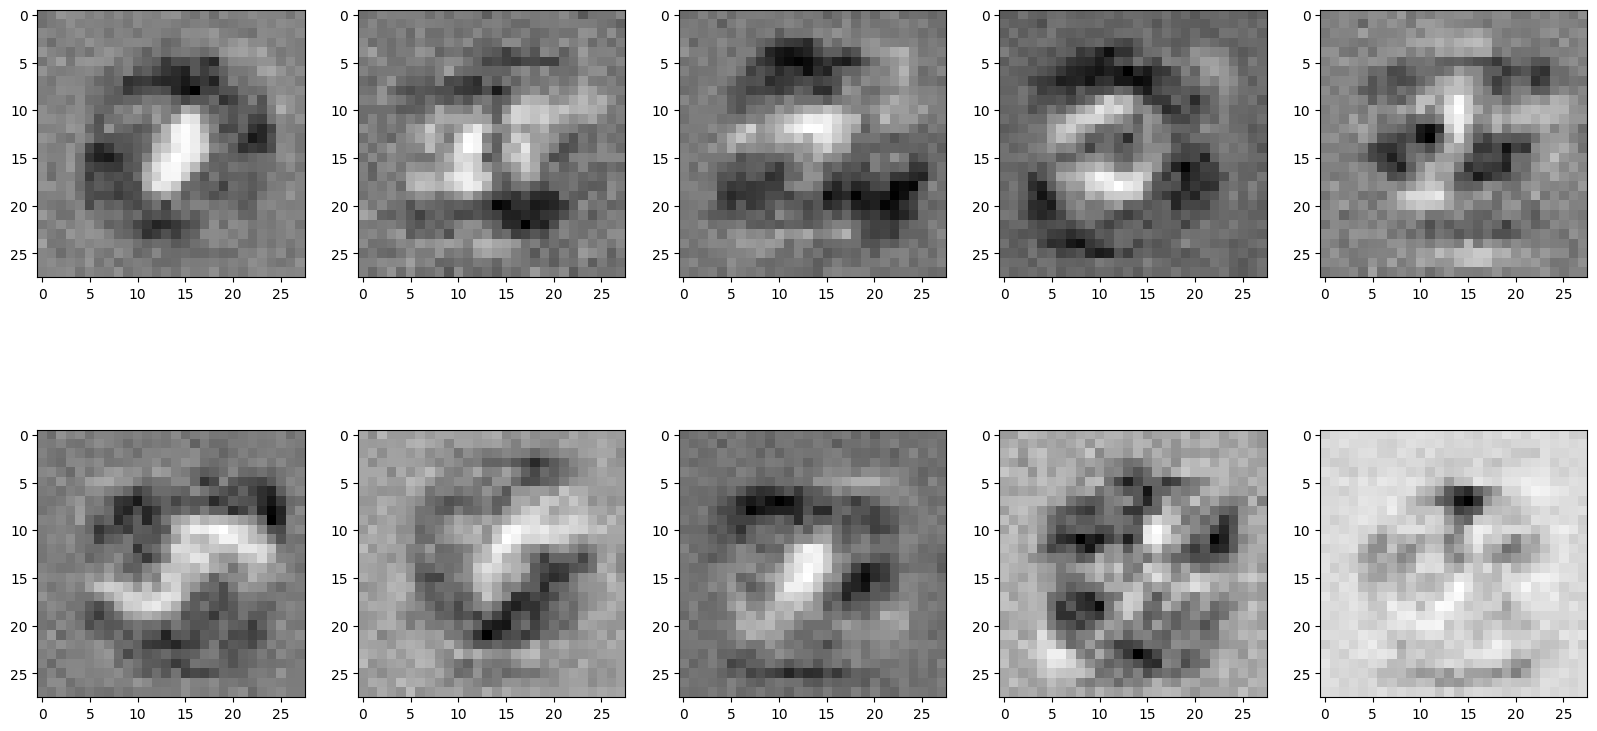

In [6]:
plt.figure(figsize=(20, 10))
rows, cols = 2, 5
for row in range(rows):
    for col in range(cols): 
        n = cols * row + col
        plt.subplot(rows,cols,n+1)    
        input = image_from_output(network,n)
        show_image(input) 

plt.show()

In [7]:
#print(network.reverse(create_output(0)))
print(create_output(0))
network.query(network.reverse(create_output(1)).flatten())


[0.99 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


array([0.05966193, 0.09403208, 0.07510307, 0.37779629, 0.0430308 ,
       0.29728127, 0.09966899, 0.01722372, 0.65453631, 0.22270938])